# Overview 

This notebook implemets a Topic Model using LDA for the dataset produced as part of the Sexual Assault Coverage project described here: https://github.com/tomkreker/SexualAssaultCoverage.

It contains the following sections:
1. Data preparation
2. 5-topic LDA
3. Other less successful attempts
4. Exporting the data for plotting  (7 topics, minimize perplexity, with with cross-validation)
5. A Flourish visualization

## Data Preparation

In [1]:
# basic imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# LDA imports
from sklearn.decomposition import LatentDirichletAllocation, PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

# to load files
import os

# to visualize the LDA results
import pyLDAvis
import pyLDAvis.gensim  
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()



In [2]:
# open kulan files from two folders

files = []
for i in os.listdir('textfiles/textfiles_norm_full_nothp'):
    loc = 'textfiles/textfiles_norm_full_nothp/'+i
    file = open(loc, 'r', encoding="utf8")
    with file:
        content = file.readlines()
        files.append(content[0])
        
for i in os.listdir('textfiles/textfiles_norm_full_hp'):
    #loc = 'textfiles/'+i
    loc = 'textfiles/textfiles_norm_full_hp/'+i
    file = open(loc, 'r', encoding="utf8")
    with file:
        content = file.readlines()
        files.append(content[0])

In [3]:
#os.listdir('textfiles_norm_full_nothp')

In [4]:
# unify words that were very similar but not caught by the Hebrew lemmatizer:
# sex and sexual, suspect and suspicion, complained and complaint, arrested and arrest, charged and charge
for i in range(len(files)):
    files[i]=files[i].replace( 'מיני' , 'מינ').replace( 'חשוד' , 'חשד').replace( 'התלוננ' , 'תלונה').replace( 'נעצר' , 'מעצר').replace( 'נאשמ' , 'אישומ')
    files[i]=files[i].replace( 'האריכ' , 'הארכה').replace( 'הוארכ' , 'הארכה')

In [5]:
# load stopwords
file = open('./data/heb_stopwords_topic.txt', 'r', encoding="utf8")
with file:
    stopwords = file.readlines()

stopwords=[s.rstrip() for s in stopwords]
        
def final_letter(word):
    '''A function that changes the final letter of the word to its mid-sentence form (it differs from end-sentences)
       because the text used here has only mid-word letters after the cleaning process.'''
    if word.endswith('ם'):
        word = word[:-1]+'מ'

    elif word.endswith('ך'):
        word = word[:-1]+'כ'

    elif word.endswith('ן'):
        word = word[:-1]+'נ'

    elif word.endswith('ף'):
        word = word[:-1]+'פ'

    elif word.endswith('ץ'):
        word = word[:-1]+'צ'
        
    return word
        
stopwords = [final_letter(s) for s in stopwords]
print('Number of stopwods:', len(stopwords))

Number of stopwods: 1150


## Fit and Visualize 5-topic Model

In [6]:
# define number of features
no_features = 1000

# prepare count of words for LDA
# max_df was set to 0.6 after tweaking to remove noise, min_df similarly to prevent lots of city and person names
# I also tried counting ngrams but the lemmatization prevented from doing this effectively since it did not take
# them into account (not in the tool's abilities)

tf_vectorizer = CountVectorizer(max_df=0.6, min_df=50, max_features=no_features, stop_words=stopwords)  

# fit on all files
tf = tf_vectorizer.fit_transform(files)

# get feature names
tf_feature_names = tf_vectorizer.get_feature_names()

In [7]:
# Fit LDA

# When learning method is batch, the decay and offset parameters are not used, but since
# I tried both I specify them anyway
lda = LatentDirichletAllocation(n_components=5, learning_method='batch', evaluate_every = -1, random_state=1, n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(n_components=5, n_jobs=-1, random_state=1)

In [8]:
# visualize
vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.119744  0.135234       1        1  24.271021
2      0.052100  0.097437       2        1  22.107158
3     -0.257683  0.008277       3        1  19.651298
0     -0.066602 -0.080319       4        1  18.907197
1      0.152441 -0.160629       5        1  15.063326, topic_info=       Term        Freq       Total Category  logprob  loglift
76     מורה  311.000000  311.000000  Default  30.0000  30.0000
117  עירייה  293.000000  293.000000  Default  29.0000  29.0000
77       מח  244.000000  244.000000  Default  28.0000  28.0000
129    קצינ  232.000000  232.000000  Default  27.0000  27.0000
21     בכיר  306.000000  306.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
134     רשת   35.671296  233.139654   Topic5  -4.3719   0.0156
98     ניצל   32.990358  247.951429   Topic5  -4.4500  -0.1241
64      כוח   27.913911  195.903964   Topic5  -4.6171  -0.0556
147   תפקיד   23.153100  378.114245   Topic5  -4.8041  -0.9002
124  ציבורי   22.678970  222.405428   Topic5  -4.8248  -0.3902

[229 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         3  0.146037   אגפ
0         4  0.847014   אגפ
1         1  0.403906  אופי
1         2  0.052683  אופי
1         3  0.395125  אופי
...     ...       ...   ...
148       1  0.200380   תקפ
148       2  0.577095   תקפ
148       3  0.012023   תקפ
148       4  0.004008   תקפ
148       5  0.208396   תקפ

[536 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 1, 2])

## 7-topic model

In [9]:
# Fit LDA

# When learning method is batch, the decay and offset parameters are not used, but since
# I tried both I specify them anyway
lda7 = LatentDirichletAllocation(n_components=7, learning_method='batch', evaluate_every = -1, random_state=1, n_jobs=-1)
lda7.fit(tf)

LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=1)

In [10]:
# visualize
# it looks great, but not coherent enough
vis7 = pyLDAvis.sklearn.prepare(lda7, tf, tf_vectorizer)
vis7

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.268837 -0.025854       1        1  17.575418
6     -0.074882  0.241041       2        1  16.188554
1     -0.103820 -0.033480       3        1  14.825648
2     -0.019374 -0.116748       4        1  13.736111
0      0.122845 -0.009941       5        1  13.143749
4     -0.180928 -0.117599       6        1  12.672031
5     -0.012678  0.062579       7        1  11.858490, topic_info=       Term        Freq       Total Category  logprob  loglift
76     מורה  314.000000  314.000000  Default  30.0000  30.0000
117  עירייה  291.000000  291.000000  Default  29.0000  29.0000
114   סרטונ  255.000000  255.000000  Default  28.0000  28.0000
77       מח  240.000000  240.000000  Default  27.0000  27.0000
129    קצינ  229.000000  229.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
124  ציבורי   40.416864  221.226404   Topic7  -4.0077   0.4322
128    קיומ   28.270593  122.641078   Topic7  -4.3652   0.6647
31     הורה   45.400078  359.142043   Topic7  -3.8915   0.0639
116   עירומ   38.123865  313.099412   Topic7  -4.0661   0.0264
50    חינוכ   27.724244  188.853348   Topic7  -4.3847   0.2135

[299 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.178420   אגפ
0         5  0.257718   אגפ
0         7  0.555085   אגפ
1         1  0.379339  אופי
1         2  0.308765  אופי
...     ...       ...   ...
148       1  0.003942   תקפ
148       2  0.059126   תקפ
148       3  0.717397   תקפ
148       4  0.122194   תקפ
148       6  0.094602   תקפ

[735 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 2, 3, 1, 5, 6])

# Document-Topic Matrix and Hisograms

In [11]:
### Create document-topic matrix

# get the mixture of topics per document
lda_output = lda.transform(tf)

# set topic names
topicnames = ["Internet Crimes","Assault Descriptions","Public Authorities","Police/Army","School"]
#topicnames = ["Police/Army", "School", "Assault Descriptions", 'Descriptions/Club', "Public Authorities", "Internet Crimes", 'Mix']

# set index
docnames = ['Article' + str(i) for i in range(len(files))]

# make into a dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# # attempt to turn 7 into 5
# copy_for_classification = df_document_topic.copy()
# copy_for_classification.loc[:,'Descriptions/Club'] = 0
# copy_for_classification.loc[:,'Mix'] = 0
# main_topic_num = np.argmax(copy_for_classification.values, axis=1)


# Get dominant topic for each document
main_topic_num = np.argmax(df_document_topic.values, axis=1)
main_topic = [topicnames[i] for i in main_topic_num]
df_document_topic['main_topic'] = main_topic

# Styling
def color_green(val):
    if isinstance(val, float):
        color = 'green' if val > 0.1 else 'black'
        return 'color: {col}'.format(col=color)
    else:
        return val

def make_bold(val):
    if isinstance(val, float):
        weight = 700 if val > 0.1 else 400
        return 'font-weight: {weight}'.format(weight=weight)
    else:
        return val

# Apply Style
df_document_topics_style = df_document_topic.style.applymap(color_green).applymap(make_bold)

df_document_topics_style

In [12]:
# main topic distribution
counts = np.unique(main_topic_num, return_counts=True)
print(topicnames)
print(counts[1]/np.sum(counts))

['Internet Crimes', 'Assault Descriptions', 'Public Authorities', 'Police/Army', 'School']
[0.19790576 0.12146597 0.27853403 0.13717277 0.25445026]


In [13]:
# Average presece per topic (ignoring the main_topic column - very similar to the main topic distribution)
np.mean(df_document_topic, axis=0)

Internet Crimes         0.191153
Assault Descriptions    0.137323
Public Authorities      0.267958
Police/Army             0.159778
School                  0.244000
dtype: float64

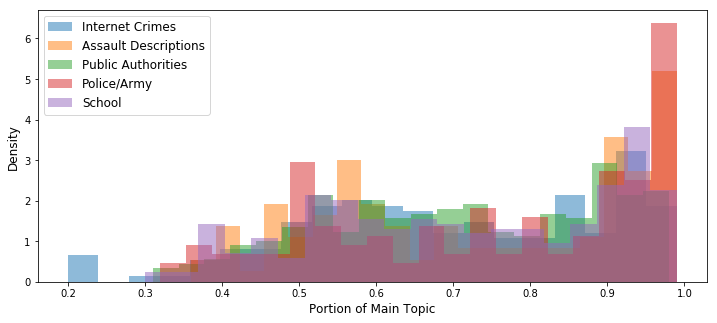

In [14]:
# distribution of how high was the highest value that made it the dominant topic
num_topics=5
plt.figure(figsize=(12,5))
cmap = plt.cm.get_cmap("Accent",num_topics)
plt.set_cmap(cmap)
for i in range(len(topicnames)):
    only_topic = df_document_topic[main_topic_num==i]
    highest_prob = np.max(only_topic.drop(['main_topic'],axis=1).values, axis=1)
    plt.hist(highest_prob, label=topicnames[i], alpha=0.5, bins=20, density=True)
    
plt.xlabel('Portion of Main Topic', fontsize=12)
plt.ylabel('Density',  fontsize=12)
plt.legend( fontsize=12)
plt.show()

# Plotting articles with PCA
Below I used PCA on the LDA output to plot all articles on a 2d plane with their main topic as the color, but did not include in the submission because it was getting long and did not add insights on top of other visualizations without further discussions (close reading of some of these results, assessing the similarity, etc.)

In [15]:
tf[0]

<1x149 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

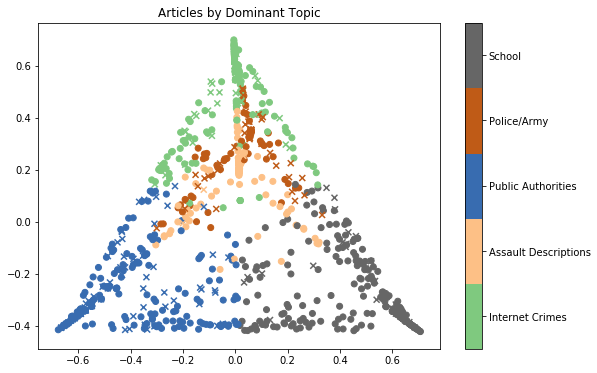

In [17]:
# KMeans produces the same result as just using the dominant topic
#from sklearn.cluster import KMeans
#clusters = KMeans(n_clusters=5, random_state=1).fit_predict(lda_output)

# get numeric main topic
clusters = main_topic_num

# fit PCA and transform data
pca = PCA(n_components=2)  # 2 components
pca_output = pca.fit_transform(lda_output)

# svd - not successful
#svd_model = TruncatedSVD(n_components=2)  # 2 components
#lda_output_svd = svd_model.fit_transform(tf)

# get the two components
x = pca_output[:, 0]
y = pca_output[:, 1]

# Plot PCA
plt.figure(figsize=(9, 6))
num_topics=5
# get colormap
cmap = plt.cm.get_cmap("Accent",num_topics)

# plot
hp = len(os.listdir('./textfiles/textfiles_norm_full_nothp'))

plt.scatter(x[:hp], y[:hp], c=clusters[:hp], label=clusters[:hp], cmap=cmap, vmin=0,vmax=num_topics, marker='o')
plt.scatter(x[hp:], y[hp:], c=clusters[hp:], label=clusters[hp:], cmap=cmap, vmin=0,vmax=num_topics, marker='x')


# create colorbar
cb = plt.colorbar()
labels = topicnames
loc = np.arange(0, num_topics, 1) + .5
cb.set_ticks(loc)
cb.set_ticklabels(labels)

#labels
plt.xlabel('')
plt.ylabel('')
plt.title("Articles by Dominant Topic", )
plt.show()

In [18]:
# high profile indicator
num_nothp = len(os.listdir('./textfiles/textfiles_norm_full_nothp'))
num_hp = len(os.listdir('./textfiles/textfiles_norm_full_hp'))
hp = np.concatenate([np.full(num_nothp, 'circle'), np.full(num_hp, 'star')])

In [20]:
topics_df = pd.DataFrame({'PC1':x, 'PC2':y, 'main_topic':clusters, 'high_profile':hp})
topics_df

# export pickle
#pickle.dump(topics_df, open( "topicmodel.p", "wb"))

,PC1,PC2,main_topic,high_profile
0,-0.603072,-0.363158,2,circle
1,-0.191281,-0.275265,2,circle
2,0.671467,-0.396413,4,circle
3,0.411895,-0.412315,4,circle
4,0.664259,-0.390988,4,circle
...,...,...,...,...
940,-0.345417,-0.396038,2,star
941,-0.665773,-0.407881,2,star
942,-0.637826,-0.387531,2,star
943,-0.312340,-0.173773,2,star


In [21]:
# number of high profiles
for i in range(5):
    only_topic = topics_df[topics_df.main_topic==i]
    print(topicnames[i],'num high profiles:', np.where(only_topic.high_profile=='star', 1, 0).sum())

Internet Crimes num high profiles: 68
Assault Descriptions num high profiles: 4
Public Authorities num high profiles: 73
Police/Army num high profiles: 56
School num high profiles: 26


In [28]:
# show visualization produced in Flourish
from IPython.core.display import display, HTML

viz='<div class="flourish-embed flourish-scatter" data-src="visualisation/4711320"><script src="https://public.flourish.studio/resources/embed.js"></script></div>'
display(HTML(viz))

In [ ]:
# # old plotly figure
# fig = px.scatter(topic_final_df, x='PC1', y='PC2', color=main_topic_str, symbol='high_profile', 
#                  custom_data=['title', 'subtitle_hover', 'dt_date'], 
#                  width=800, height=600)

# # add hover tooltip
# fig.update_traces(hoverinfo='text' , 
#     hovertemplate =
#     '<b>Date</b>: %{customdata[2]}'+
#     '<br><b>Title</b>: %{customdata[0]}<br>',
#    # '<b>Subtitle</b>: %{customdata[1]}',
#     showlegend = True)

# # background spacing
# fig.update_layout(
#     margin=dict(l=20, r=60, t=20, b=20),
#     paper_bgcolor="white"
# )
                                         

# fig.update_layout(hoverlabel_align = 'right')

# #fig.update_layout(legend_orientation="h")

# fig.show()

# Appendix - Minimizing Perplexity with CV

In [ ]:
# create an LDA object whose score is perplexity and not log likelihood 
# I used it for CV after the regular one did not seem to work well, but it did not change much

class PerplexityLDA(LatentDirichletAllocation):

    def score(self, X, y=None):
        score = super(PerplexityLDA, self).perplexity(X, sub_sampling=False)

        # setting it to be negative because lower perplexity is better
        return -1*score

In [ ]:
# grid search number of topics and learning decay - also tried with topic number before

# Define Search Param
search_params = {'learning_decay': [0.1, 0.3, 0.5, 0.7], 'learning_offset': [10., 30., 50.]}

# Init the Model
lda_for_cv = PerplexityLDA(n_components=5, batch_size=128, evaluate_every = -1, random_state=1,
                                       learning_method='online', max_iter=10, n_jobs=-1)
# Init Grid Search Class
model = GridSearchCV(lda_for_cv, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

In [ ]:
# chosen model
best_model = model.best_estimator_
# parameters
print("Best Model's Parameters:", model.best_params_)

In [ ]:
# visualize
vis7 = pyLDAvis.sklearn.prepare(best_model, tf, tf_vectorizer)
vis7